# Logistic Regression: Image Recognition
## Binary classification: cat or not a cat?

A logistic regression inspired by the Neural Networks and Deep Learning course (https://www.coursera.org/learn/neural-networks-deep-learning/). Data set from https://www.kaggle.com/mriganksingh/cat-images-dataset. The purpose of this project is to create an image-recognition algorithm that can identify whether an image contains a cat or not using logistic regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import os

%matplotlib inline

### 1. Load and modify data

The function load_dataset() loads the data and modifies it so that both the features ($x$) and results ($y$) are well-formatted. Initially, train_set_x and test_set_x are both of shape (sample_size, img_size, img_size, $3$), where img_size is the width (and the height) of each picture in the data set and $3$ represents the RGB channels. For convenience of having a matrix $X$ of features, we transform each example (image) in initial_train_set_x and initial_test_set_x into a column vector $X_i$ of shape $(1, img\_size \times img\_size \times 3)$. To standarize the image data, we divide P by $255$, the maximum pixel value. We also modify test_set_y and train_set_y to be column vectors.
<br/>

$X_i = \begin{bmatrix}R_1\\R_2\\.\\.\\R_{img\_size}\\G_1\\.\\.\\B_{img\_size}\end{bmatrix}$
$\qquad X = \begin{bmatrix}X_1&X_2&.&.&.&X_{sample\_size}\end{bmatrix}$
$\qquad Y = \begin{bmatrix}y_1\\y_2\\.\\.\\.\\y_{sample\_size}\end{bmatrix}$

In [126]:
# Loading and modifying the data
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    initial_train_set_x = np.array(train_dataset["train_set_x"][:])  
    train_set_y = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    initial_test_set_x = np.array(test_dataset["test_set_x"][:])       
    test_set_y = np.array(test_dataset["test_set_y"][:])

    train_set_x = initial_train_set_x.reshape(initial_train_set_x.shape[0], -1).T / 255
    test_set_x = initial_test_set_x.reshape(initial_test_set_x.shape[0], -1).T / 255
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0])) 
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0])) 
    
    return initial_test_set_x, initial_train_set_x, train_set_x, train_set_y, test_set_x, test_set_y

initial_test_set_x, initial_train_set_x, train_set_x, train_set_y, test_set_x, test_set_y = load_dataset()

In [127]:
# Testing data modifications
m_train = initial_train_set_x.shape[0]      #number of examples in train set
m_test = initial_test_set_x.shape[0]        #number of examples in test set
img_size = initial_train_set_x.shape[1]     #image width = image height

print("train set examples: " + str(m_train))
print("test set examples: " + str(m_test))
print("image height/width: " + str(img_size) + "\n")
print("shape of initial train set x: " + str(initial_train_set_x.shape))
print("expected shape of train set x: " + "(" + str(img_size*img_size*3) + ", " + str(m_train) + ")")
print("shape of train set x:" + str(train_set_x.shape) + "\n")
print("shape of initial test set x: " + str(initial_test_set_x.shape))
print("expected shape of test set x: " + "(" + str(img_size*img_size*3) + ", " + str(m_test) + ")")
print("shape of test set x: " + str(test_set_x.shape) + "\n")
print("shape of train set y: " + str(train_set_y.shape))
print("shape of test set y: " + str(test_set_y.shape))

train set examples: 209
test set examples: 50
image height/width: 64

shape of initial train set x: (209, 64, 64, 3)
expected shape of train set x: (12288, 209)
shape of train set x:(12288, 209)

shape of initial test set x: (50, 64, 64, 3)
expected shape of test set x: (12288, 50)
shape of test set x: (12288, 50)

shape of train set y: (1, 209)
shape of test set y: (1, 50)


### 2. Model

Given $X_i, Y_i$ as defined above, with $i \in \{1, ..., m\}, m = 209$, then, for every $i$, we define the mathematical model for the logistic regression as follows:
Let $Z_i = w^TX_i + b$ where $w \in \mathbb{R}^{12288}$ and $b \in \mathbb{R}$. Let $A_i$ be the approximation of $Y_i$, $A_i = \sigma (Z_i)$ (where $\sigma$ is the sigmoid function $\sigma(x) = \frac{1}{1 + e^{-x}}$). The loss (or the error) function $L(A_i, Y_i)$ is chosen such that $L(A_i, Y_i) = - (Y_i\log(A_i) + (1 - Y_i)\log(1 - A_i))$ and the cost function $J(w, b) = -\frac{1}{m} \sum^m_{i = 1} L(A_i, Y_i)$. The goal is to learn the parameters $w, b$ by minimizing the cost function $J$, and then use the parameters to make predictions on the test set.

### 3. Algorithm

#### a. Auxiliary functions

In [143]:
#sigmoid function
def sigma(x):
    return 1 / (1 + np.exp(-x))

assert sigma(0) == 0.5
assert sigma(5) - 0.99330715 < 10**(-5)

#function that transforms label (1/0) into cat/not a cat
def binary_to_cat(x):
    if x:
        return "a cat"
    return "not a cat"

#### b. Initializing parameters w, b

In [129]:
def initialize_param(size):
    w = np.zeros((size, 1))
    b = 0
    return w, b

wtest, btest = initialize_param(3)
assert wtest.shape == (3, 1) and btest == 0

#### c. Propagation steps

We have to implement forward and backword propagation. <br/>
Forward propagation:<br/>
- compute the results after linear and activation functions ($Z, A$)
- compute the cost function $J$
<br/>


Backward propagation:
- compute gradient by calculating the partial derivatives of the cost function as follows:
$$\frac{\partial J}{\partial w} = \frac{1}{m} X(A-Y)^T$$
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum^m_{i=1} (A_i - Y_i)$$

In [130]:
def propagation(X, Y, w, b):
    m = X.shape[1]
    
    #forward
    Z = np.dot(w.T, X) + b
    A = sigma(Z)
    cost = - (1 / m) * (np.sum(np.dot(Y, np.log(A).T) + np.dot(1 - Y, np.log(1 - A).T)))   #transpose A for mathcing product shape purposes
    cost = np.squeeze(cost)
    
    #backward
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    gradients = [dw, db]
    
    return gradients, cost

In [131]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagation(X, Y, w, b)
print ("dw = " + str(grads[0]))
print ("db = " + str(grads[1]))
print ("cost = " + str(cost))

dw = [[ 0.99845601]
 [ 2.39507239]]
db = 0.00145557813678
cost = 5.80154531939


#### d. Optimize parameters

To learn $w, b$ while minimizing the cost function $J$, we update the parameters as follows (where $\alpha$ is the learning rate):
$$w := w - \alpha \frac{\partial J}{\partial w}$$
$$b := b - \alpha \frac{\partial J}{\partial b}$$

In [132]:
def optimization(X, Y, w, b, num_iterations, alpha):
    costs = []
    
    for i in range(num_iterations):
        gradients, cost = propagation(X, Y, w, b)
        
        w = w - alpha * gradients[0]
        b = b - alpha * gradients[1]
        
        if not i % 100:
            costs.append(cost)
    
    parameters = [w, b]
    return parameters, gradients, costs

In [133]:
params, grads, costs = optimization(X, Y, w, b, 100, 0.009)

print ("w = " + str(params[0]))
print ("b = " + str(params[1]))
print ("dw = " + str(grads[0]))
print ("db = " + str(grads[1]))

w = [[ 0.19033591]
 [ 0.12259159]]
b = 1.92535983008
dw = [[ 0.67752042]
 [ 1.41625495]]
db = 0.219194504541


#### e. Predict labels

With the opimizied $w, b$, we can now predict $Y$ using the activation $A$. If $A_i \leq 0.5$, $Y_i$ will be $0$ (not a cat). Else, $Y_i$ will be $1$ (cat).

In [134]:
def prediction(X, w, b):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    A = sigma(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0][i] += np.where(A[0][i] <= 0.5, 0, 1)
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [135]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2], [1.2, 2., 0.1]])
print ("predictions = " + str(prediction(X, w, b)))

predictions = [[ 1.  1.  0.]]


### 4. Build model()

Using all of the auxiliary functions from the previous section, we can now create a model() function that encapsulates the entire algorithm.

In [140]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, alpha):
    
    #initialize parameters
    w, b = initialize_param(X_train.shape[0])
    
    #learning w, b
    parameters, gradients, costs = optimization(X_train, Y_train, w, b, num_iterations, alpha)
    w = parameters[0]
    b = parameters[1]
    
    #prediction
    Y_prediction_train = prediction(X_train, w, b)
    Y_prediction_test = prediction(X_test, w, b)
    
    #evaluate accuracy
    print("train accuracy: {}%".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    return Y_prediction_train, Y_prediction_test, w, b

In [141]:
train_predicted_y, test_predicted_y, w, b = model(train_set_x, train_set_y, test_set_x, test_set_y, 2000, 0.005)

train accuracy: 99.04306220095694%
test accuracy: 70.0%


This image is not a cat. You predicted it is a cat.


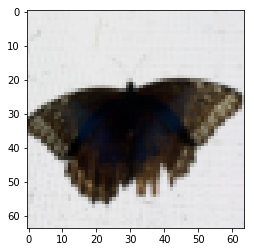

In [149]:
#wrongly classified image
index = 13

plt.imshow(test_set_x[:, index].reshape((img_size, img_size, 3)))
real_id = binary_to_cat(test_set_y[0, index])
predicted_id = binary_to_cat(int(test_predicted_y[0, index]))
print ("This image is " + real_id + ". You predicted it is " + predicted_id + ".")

### 5. Conclusions and further analysis

We can conclude that the model is working to a certain extent. The train set accuracy is over $99\%$, while the test set accuracy is $70\%$ (this is not too bad considering the limitations of logistic regression and the small size of the data set). We can further analyse the impact of changing the learning rate and the number of iterations.